In [1]:
!pip install transformers datasets rouge_score nltk xgboost


In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, PegasusTokenizer, PegasusForConditionalGeneration
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from datasets import load_dataset
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu
import xgboost as xgb

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from datasets import load_dataset

# Load the WikiText dataset
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')

# Check the number of samples in each split
train_size = len(dataset['train'])
validation_size = len(dataset['validation'])
test_size = len(dataset['test'])

print(f"Number of samples in the train split: {train_size}")
print(f"Number of samples in the validation split: {validation_size}")
print(f"Number of samples in the test split: {test_size}")


In [3]:
from datasets import load_dataset

# Load the WikiText dataset
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')

# Accessing the dataset directly and converting to a list of texts
texts = dataset['test']['text'][:100]  # Load a small subset for demonstration

# Ensure that the texts are loaded correctly
print(texts[:2])  # Print the first two texts to check



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

['', ' = Robert Boulter = \n']


In [4]:
# Install required libraries
!pip install nltk spacy
!python -m spacy download en_core_web_sm

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy

# Load Spacy's English model
nlp = spacy.load('en_core_web_sm')

# Initialize NLTK tools
nltk.download('punkt')
nltk.download('wordnet')

# Define the tokenization, lemmatization, and stemming functions

def tokenize_text(text):
    # Sentence tokenization
    sentences = sent_tokenize(text)

    # Word tokenization
    words = word_tokenize(text)

    return sentences, words

def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

def stem_words(words):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

def spacy_preprocessing(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_punct]
    return tokens, lemmatized_tokens

def preprocess_texts(texts):
    preprocessed_texts = []
    for text in texts:
        sentences, words = tokenize_text(text)
        lemmatized_words = lemmatize_words(words)
        stemmed_words = stem_words(words)
        tokens, lemmatized_tokens = spacy_preprocessing(text)

        preprocessed_texts.append({
            'original': text,
            'sentences': sentences,
            'words': words,
            'lemmatized_words': lemmatized_words,
            'stemmed_words': stemmed_words,
            'spacy_tokens': tokens,
            'spacy_lemmatized_tokens': lemmatized_tokens
        })

    return preprocessed_texts

# Load the WikiText dataset
from datasets import load_dataset
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')
texts = dataset['test']['text'][:100]  # Load a small subset for demonstration

# Ensure that the texts are loaded correctly
print(texts[:2])  # Print the first two texts to check

# Process the texts
preprocessed_data = preprocess_texts(texts)

# Print the first two preprocessed texts to check
for data in preprocessed_data[:2]:
    print(data)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


['', ' = Robert Boulter = \n']
{'original': '', 'sentences': [], 'words': [], 'lemmatized_words': [], 'stemmed_words': [], 'spacy_tokens': [], 'spacy_lemmatized_tokens': []}
{'original': ' = Robert Boulter = \n', 'sentences': [' = Robert Boulter ='], 'words': ['=', 'Robert', 'Boulter', '='], 'lemmatized_words': ['=', 'Robert', 'Boulter', '='], 'stemmed_words': ['=', 'robert', 'boulter', '='], 'spacy_tokens': [' ', '=', 'Robert', 'Boulter', '=', '\n'], 'spacy_lemmatized_tokens': [' ', '=', 'Robert', 'Boulter', '=', '\n']}


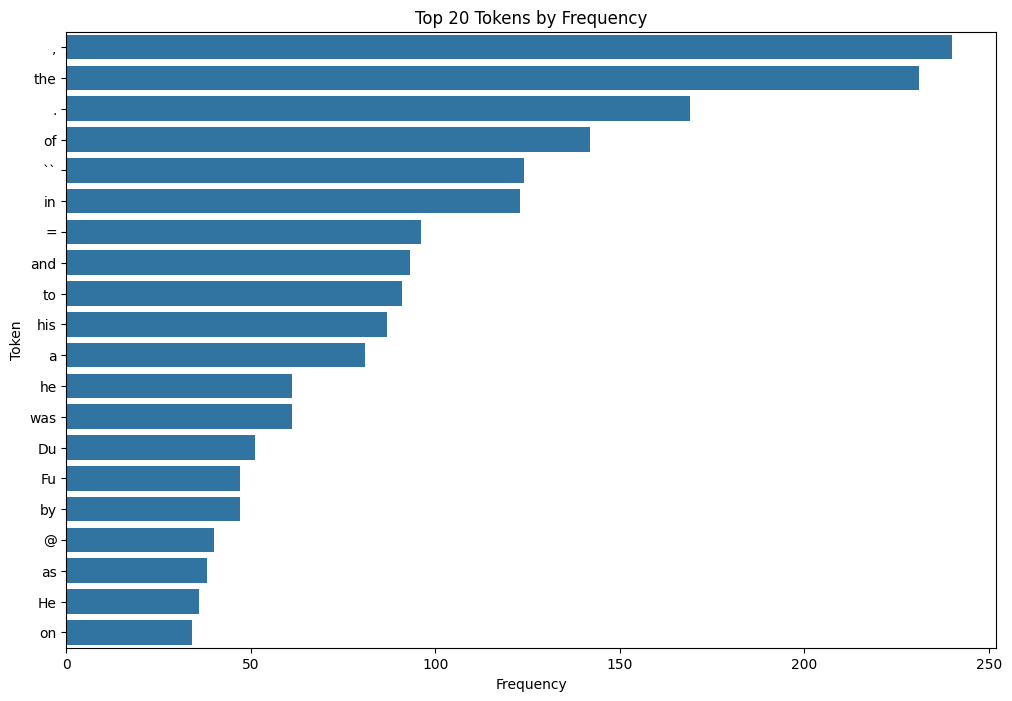

In [5]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

def plot_token_distribution(preprocessed_data):
    all_tokens = [token for data in preprocessed_data for token in data['words']]

    # Count frequency of tokens
    token_freq = nltk.FreqDist(all_tokens)

    # Create a DataFrame for plotting
    token_df = pd.DataFrame(token_freq.items(), columns=['Token', 'Frequency'])
    token_df = token_df.sort_values(by='Frequency', ascending=False).head(20)  # Top 20 tokens

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frequency', y='Token', data=token_df)
    plt.title('Top 20 Tokens by Frequency')
    plt.show()

# Example usage
plot_token_distribution(preprocessed_data)


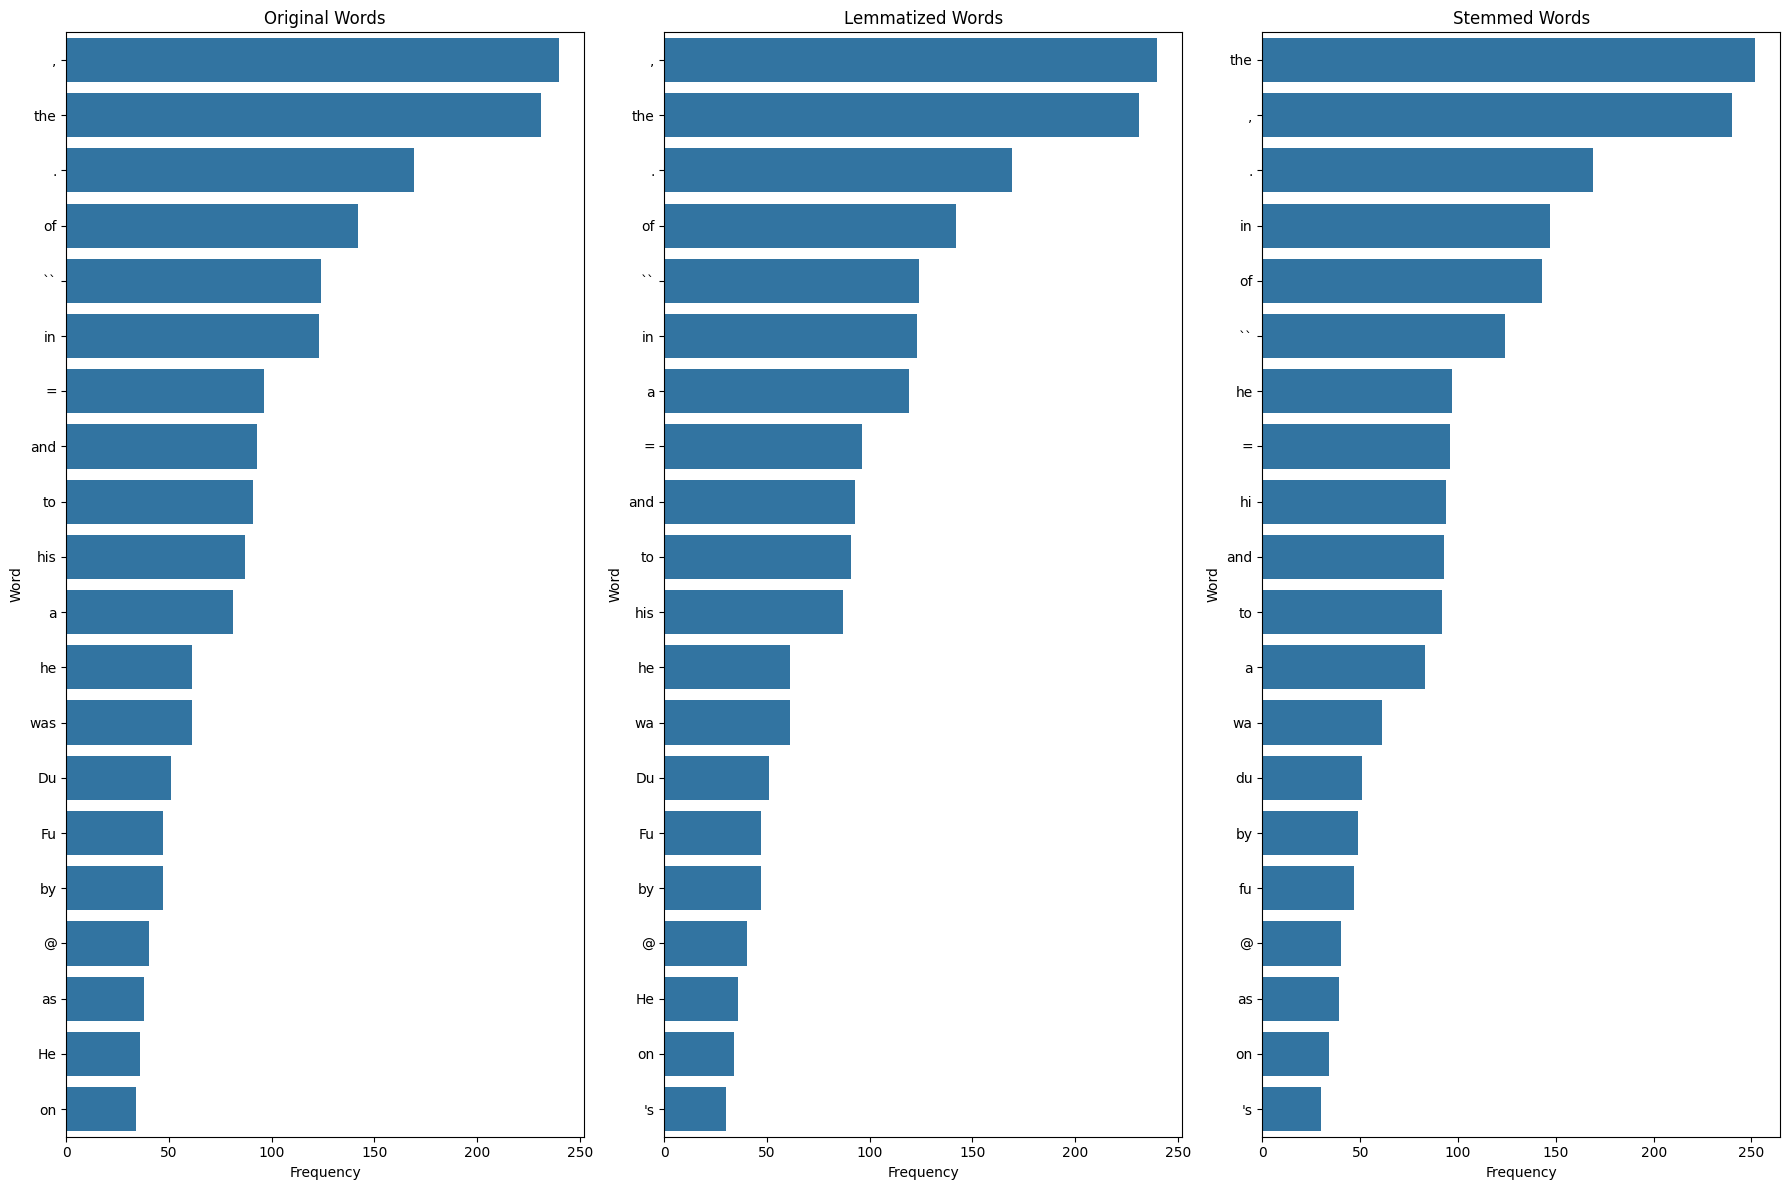

In [6]:
def plot_lemma_stem_comparison(preprocessed_data):
    original_words = [word for data in preprocessed_data for word in data['words']]
    lemmatized_words = [word for data in preprocessed_data for word in data['lemmatized_words']]
    stemmed_words = [word for data in preprocessed_data for word in data['stemmed_words']]

    # Count frequency of words
    original_freq = nltk.FreqDist(original_words)
    lemmatized_freq = nltk.FreqDist(lemmatized_words)
    stemmed_freq = nltk.FreqDist(stemmed_words)

    # Create DataFrames for plotting
    original_df = pd.DataFrame(original_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(20)
    lemmatized_df = pd.DataFrame(lemmatized_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(20)
    stemmed_df = pd.DataFrame(stemmed_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(18, 12))

    plt.subplot(1, 3, 1)
    sns.barplot(x='Frequency', y='Word', data=original_df)
    plt.title('Original Words')

    plt.subplot(1, 3, 2)
    sns.barplot(x='Frequency', y='Word', data=lemmatized_df)
    plt.title('Lemmatized Words')

    plt.subplot(1, 3, 3)
    sns.barplot(x='Frequency', y='Word', data=stemmed_df)
    plt.title('Stemmed Words')

    plt.tight_layout()
    plt.show()

# Example usage
plot_lemma_stem_comparison(preprocessed_data)


In [7]:
def summarize_with_bart(texts):
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

    summaries = []
    for text in texts:
        inputs = tokenizer.encode("summarize: " + text, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

def summarize_with_t5(texts):
    tokenizer = T5Tokenizer.from_pretrained('t5-small')
    model = T5ForConditionalGeneration.from_pretrained('t5-small')

    summaries = []
    for text in texts:
        inputs = tokenizer.encode("summarize: " + text, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

def summarize_with_pegasus(texts):
    tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')
    model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')

    summaries = []
    for text in texts:
        inputs = tokenizer.encode(text, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries


In [8]:
def classify_with_bert(texts, labels):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1).numpy()

    return predictions

def classify_with_xgboost(texts, labels):
    # Placeholder for feature extraction
    # You need to transform texts into features for XGBoost
    # Here we use a dummy example assuming 'texts' are already features
    dmatrix = xgb.DMatrix(texts)
    model = xgb.XGBClassifier()
    model.fit(texts, labels)

    predictions = model.predict(texts)
    return predictions


In [9]:
def evaluate_summarization(original_texts, summaries):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    bleu_scores = []

    for orig, sum_text in zip(original_texts, summaries):
        rouge_scores = scorer.score(orig, sum_text)
        bleu_scores.append(sentence_bleu([orig.split()], sum_text.split()))

    return rouge_scores, bleu_scores

def evaluate_classification(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')

    return accuracy, precision, recall


In [ ]:
# Summarize texts
bart_summaries = summarize_with_bart(texts)
t5_summaries = summarize_with_t5(texts)
pegasus_summaries = summarize_with_pegasus(texts)

# Load some dummy labels for classification (replace with actual labels)
dummy_labels = np.random.randint(0, 2, size=len(texts))

# Classify texts
bert_predictions = classify_with_bert(texts, dummy_labels)
xgboost_predictions = classify_with_xgboost(texts, dummy_labels)

# Evaluate Summarization
rouge_bart, bleu_bart = evaluate_summarization(texts, bart_summaries)
rouge_t5, bleu_t5 = evaluate_summarization(texts, t5_summaries)
rouge_pegasus, bleu_pegasus = evaluate_summarization(texts, pegasus_summaries)

# Evaluate Classification
accuracy_bert, precision_bert, recall_bert = evaluate_classification(dummy_labels, bert_predictions)
accuracy_xgboost, precision_xgboost, recall_xgboost = evaluate_classification(dummy_labels, xgboost_predictions)

print("ROUGE Scores (BART):", rouge_bart)
print("BLEU Scores (BART):", bleu_bart)

print("ROUGE Scores (T5):", rouge_t5)
print("BLEU Scores (T5):", bleu_t5)

print("ROUGE Scores (Pegasus):", rouge_pegasus)
print("BLEU Scores (Pegasus):", bleu_pegasus)

print("BERT Classification - Accuracy:", accuracy_bert)
print("BERT Classification - Precision:", precision_bert)
print("BERT Classification - Recall:", recall_bert)

print("XGBoost Classification - Accuracy:", accuracy_xgboost)
print("XGBoost Classification - Precision:", precision_xgboost)
print("XGBoost Classification - Recall:", recall_xgboost)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
